# Imports

In [1]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw
from numpy import asarray
from bs4 import BeautifulSoup as bs

from object_detection.utils import config_util, visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
porcentagem_acerto = 0.1

# Funções de Controle de Imagem

In [3]:
def criarArquivo(mensagem, path):
    path = path.replace("./results/", "./results/info/")
    path = path.replace(".jpg", ".txt")
    mensagem = mensagem.replace("WBCs", "")
    arquivo = open(path, "w")
    arquivo.write("WBC\n")
    arquivo.write(mensagem)
    arquivo.close()

In [4]:
# Converte a imagem em array
def convertImageToArray(path):
    image = Image.open(path)
    array = asarray(image)
    return array


# Imprime as detecções na imagem
def plotDetections(imagem, boxes, classes, scores, categoria, nome=None):
    imagemDeteccao = imagem.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        imagemDeteccao, boxes, classes, scores, categoria, use_normalized_coordinates=True, min_score_thresh=porcentagem_acerto)

    if nome:
        pontuacao = np.squeeze(scores)
        contador = 0
        for i in range(100):
            if scores is None or pontuacao[i] > porcentagem_acerto:
                contador = contador + 1

        mensagem = str(contador) + "WBCs"

        plt.imsave(nome, imagemDeteccao)
        img = Image.open(nome)
        editor = ImageDraw.Draw(img)
        editor.text((10, 10), mensagem, fill=(255, 255, 0))

        criarArquivo(mensagem, nome)

        img.save(nome)
    else:
        plt.imshow(imagemDeteccao)


# Análise dos Dados

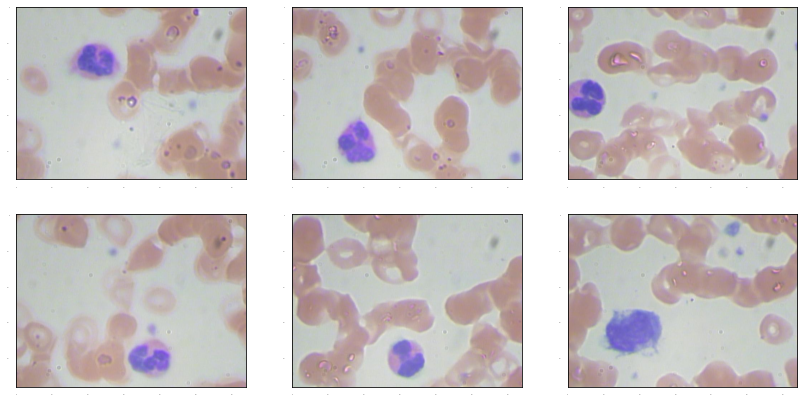

In [5]:
train_images_dir = './dataset/train/imagens/'
train_images = []

# Coleta as imagens, converte em array e salva em array geral
for elemento in os.listdir(train_images_dir):
    imagem = os.path.join(train_images_dir, elemento)
    train_images.append(convertImageToArray(imagem))

# Parâmetros para a plotagem
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# Plotagem da visualização teste
for indice in range(0, 6):
    plt.subplot(2, 3, indice+1)
    plt.imshow(train_images[indice])
plt.show()

# Leitura das Coordenadas

In [6]:
# Função para realizar a conversão das coordenadas do XML para o formato utilizado no plot
def calcularPosicao(lista):
    nome = lista[0]
    xmin = lista[1]
    ymin = lista[2]
    xmax = lista[3]
    ymax = lista[4]

    larguraImagem = 640
    alturaImagem = 480

    xmin = xmin / larguraImagem
    ymin = ymin / alturaImagem
    xmax = xmax / larguraImagem
    ymax = ymax / alturaImagem

    return [ymin, xmin, ymax, xmax]

In [7]:
# Função para coletar as coordenadas do arquivo XML
def infoCelulas(arquivo):
    celulas = []
    content = []
    with open(arquivo, "r") as file:
        content = file.readlines()
        content = "".join(content)
        bs_content = bs(content, "lxml")

        lista_objetos = bs_content.find_all("object")
        for objeto in lista_objetos:
            nome = objeto.find("name")
            xmin = objeto.find("xmin")
            ymin = objeto.find("ymin")
            xmax = objeto.find("xmax")
            ymax = objeto.find("ymax")
   
            nome = str(nome)
            xmin = str(xmin)
            ymin = str(ymin)
            xmax = str(xmax)
            ymax = str(ymax)

            nome = nome[nome.find(">")+1:nome.find("</name>")]
            xmin = int(xmin[xmin.find(">")+1:xmin.find("</xmin>")])
            ymin = int(ymin[ymin.find(">")+1:ymin.find("</ymin>")])
            xmax = int(xmax[xmax.find(">")+1:xmax.find("</xmax>")])
            ymax = int(ymax[ymax.find(">")+1:ymax.find("</ymax>")])

            celulas.append([nome, xmin, ymin, xmax, ymax])
                
    return celulas

print(infoCelulas("dataset/train/coordenadas/BloodImage_00125.xml"))

[['RBC', 333, 174, 421, 274], ['RBC', 312, 16, 416, 119], ['RBC', 173, 51, 252, 140], ['RBC', 453, 291, 538, 383], ['RBC', 408, 219, 501, 315], ['RBC', 460, 119, 553, 215], ['RBC', 287, 369, 394, 480], ['RBC', 1, 204, 68, 310], ['RBC', 201, 355, 303, 469], ['RBC', 28, 12, 119, 120], ['WBC', 104, 149, 275, 302], ['Platelets', 511, 253, 544, 285], ['Platelets', 170, 15, 202, 55], ['Platelets', 50, 77, 69, 100], ['Platelets', 376, 142, 411, 174]]


In [8]:
# Importação das coordenadas para um array
coordenadas_dir = 'dataset/train/coordenadas/'
coordenadas_info = []
titulos = []


def traduzir(nome):
    if (nome == "WBC"):
        return 1
    elif (nome == "RBC"):
        return 2
    elif (nome == "Platelets"):
        return 3
    else:
        return False


for arquivo in os.listdir(coordenadas_dir):
    celulasArquivo = infoCelulas(coordenadas_dir + arquivo)
    coordenadas_info.append(
        np.array([calcularPosicao(celulasArquivo[0])], dtype=np.float32))
    titulos.append(np.array([traduzir(celulasArquivo[0][0])]))

print(len(coordenadas_info))
print(len(titulos))


292
292


# Preparando dados para treinamento

In [9]:
# Definição da classe
wbc_id = 1
rbc_id = 2
platelets_id = 3
num_classes = 3

categorias = {wbc_id: {'id': wbc_id, 'name': 'wbc'},
              rbc_id: {'id': rbc_id, 'name': 'rbc'},
              platelets_id: {'id': platelets_id, 'name': 'platelets'}}

train_images_tensors = []
coordenadas_info_tensors = []
offset = 1
classes_tensors = []

# Função Zip = Tupla entre dois arryas (Imagens + Coordenadas)
for (train_image, coordenada, titulo) in zip(train_images, coordenadas_info, titulos):
    train_images_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image, dtype=tf.float32), axis=0))
    coordenadas_info_tensors.append(tf.convert_to_tensor(coordenada, dtype=tf.float32))
    indices = tf.convert_to_tensor(titulo - offset)
    classes_tensors.append(tf.one_hot(indices, num_classes))

print('Dados preparados')


Dados preparados


# Visualizando imagens com coordenadas

In [10]:
print(len(train_images))
print(len(coordenadas_info))
print(len(titulos))

292
292
292


In [11]:
print(coordenadas_info[6])
print(titulos[6])

[[0.2625    0.1109375 0.5104167 0.3      ]]
[1]


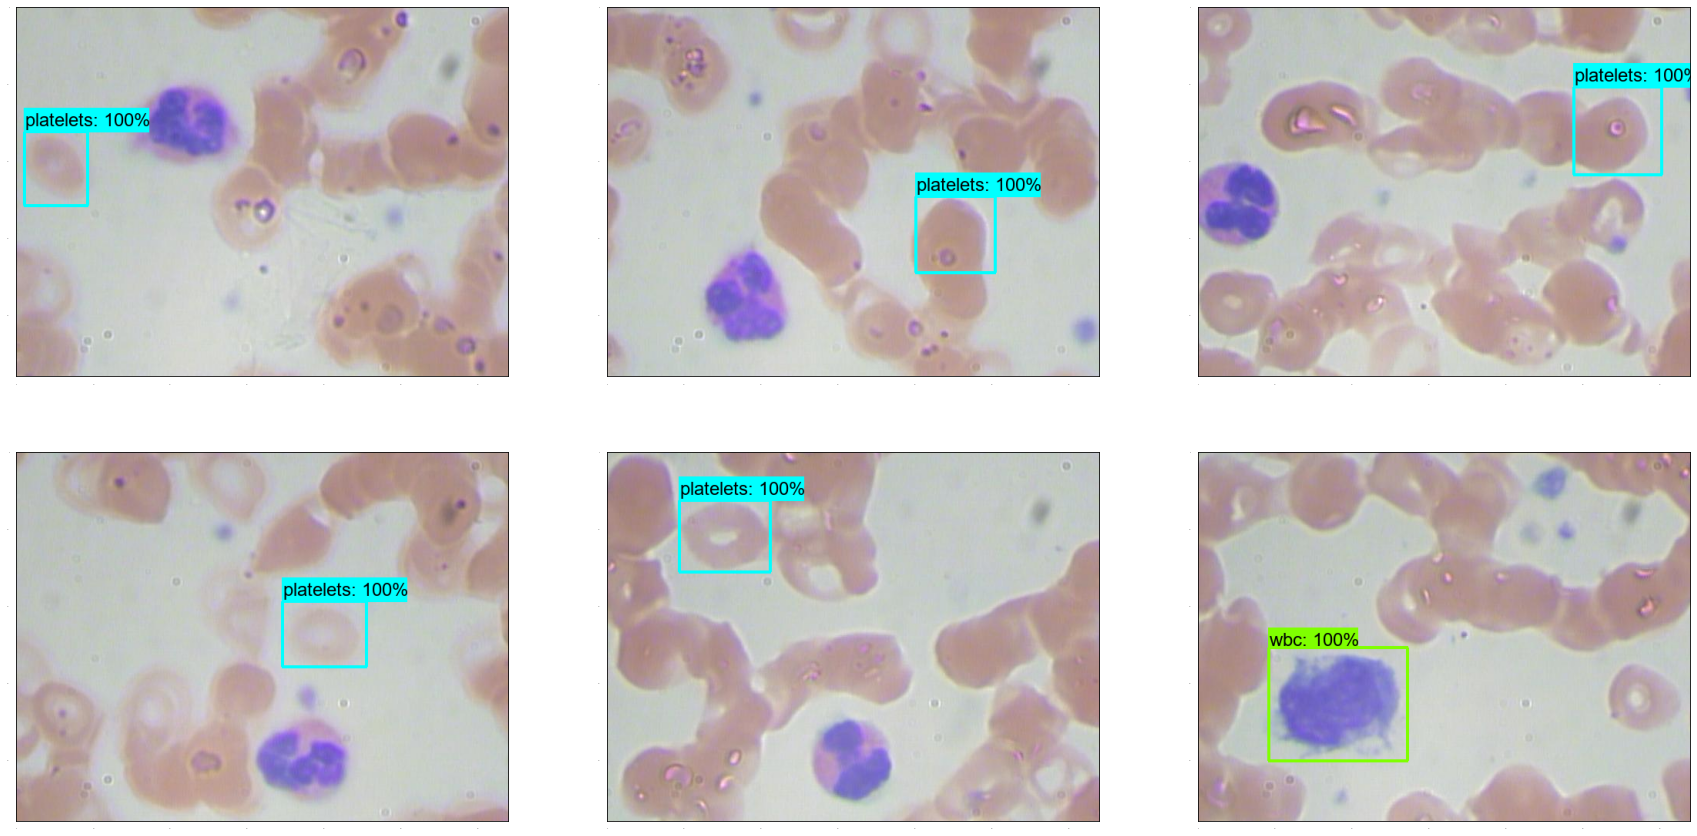

In [12]:
fake_score = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))
for indice in range(0, 6):
    plt.subplot(2, 3, indice+1)
    plotDetections(
        train_images[indice],
        coordenadas_info[indice],
        titulos[indice],
        fake_score, categorias)
plt.show()

# Criar modelo e trabalhar com checkpoints

In [13]:
tf.keras.backend.clear_session()
print('Construindo modelo e restaurando pesos para fine-tuning...', flush=True)

# Parâmetros do modelo
num_classes = 3
pipeline_config = 'models/retinaNet50_640x640/pipeline.config'
checkpoint_path = 'models/retinaNet50_640x640/checkpoint/ckpt-0'

# Importação e definição
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

# Construção do Modelo
model = model_builder.build(model_config=model_config, is_training=True)

fakebox_predictor = tf.compat.v2.train.Checkpoint(_base_tower_layers_for_heads=model._box_predictor._base_tower_layers_for_heads,
                                                  _box_prediction_head=model._box_predictor._box_prediction_head)
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=model._feature_extractor, _box_predictor=fakebox_predictor)

checkpoint = tf.compat.v2.train.Checkpoint(model=fake_model)
checkpoint.restore(checkpoint_path).expect_partial()

image, shapes = model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = model.predict(image, shapes)
_ = model.postprocess(prediction_dict, shapes)
print('Pesos restaurados!')

Construindo modelo e restaurando pesos para fine-tuning...
Pesos restaurados!


# Loop de treinamento personalizado

In [14]:
tf.keras.backend.set_learning_phase(True)

# Valores padrão
# batch_size = 4
# learning_rate = 0.01
# num_batches = 100

# Mehlores valores até agora
# batch_size = 24
# learning_rate = 0.02
# num_batches = 200

batch_size = 4
learning_rate = 0.01
num_batches = 20

# Variáveis do Treinamento
variaveis_treino = model.trainable_variables
ajuste_fino = []
prefixo_treino = ['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for variavel in variaveis_treino:
    if any([variavel.name.startswith(prefix) for prefix in prefixo_treino]):
        ajuste_fino.append(variavel)


def passoTreino(model, otimizador, ajuste_fino):
    @tf.function
    def passo(imagem_tensors, boxes_list, classes_list):

        forma = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=boxes_list, groundtruth_classes_list=classes_list)

        with tf.GradientTape() as tape:
            prepro_images = tf.concat([model.preprocess(imagem_tensor)[
                                      0] for imagem_tensor in imagem_tensors], axis=0)
            predicao_dict = model.predict(prepro_images, forma)
            perdas_dict = model.loss(predicao_dict, forma)
            perda_total = perdas_dict['Loss/localization_loss'] + \
                perdas_dict['Loss/classification_loss']
            gradientes = tape.gradient(perda_total, ajuste_fino)
            otimizador.apply_gradients(zip(gradientes, ajuste_fino))
        return perda_total

    return passo


otimizador = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
passoTreino = passoTreino(model, otimizador, ajuste_fino)

print('Fine-tuning inicializado!', flush=True)
for indice in range(num_batches):
    chaves = list(range(len(train_images)))
    random.shuffle(chaves)
    exemplo_chaves = chaves[:batch_size]

    boxes_list = [coordenadas_info_tensors[chave] for chave in exemplo_chaves]
    classes_list = [classes_tensors[chave] for chave in exemplo_chaves]
    image_tensors = [train_images_tensors[chave] for chave in exemplo_chaves]
    perda_total = passoTreino(image_tensors, boxes_list, classes_list)

    if indice % 10 == 0:
        print('Batch ' + str(indice) + ' of ' + str(num_batches)
              + ', Loss = ' + str(perda_total.numpy()), flush=True)

print('Fine-tuning realizado!')

Fine-tuning inicializado!


C:\Users\anthony.cruz.ALFA\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Batch 0 of 20, Loss = 1.2139034
Batch 10 of 20, Loss = 0.92590106
Fine-tuning realizado!


# Carregar imagens para teste e aplicar no modelo

In [15]:
test_image_dir = 'dataset/test/imagens/'
test_images = []
test_images_nomes = []

for elemento in os.listdir(test_image_dir):
    imagem = os.path.join(test_image_dir, elemento)
    test_images_nomes.append(elemento)
    test_images.append(np.expand_dims(convertImageToArray(imagem), axis=0))

@tf.function
def detectar(input_tensor):
    prepross_image, formas = model.preprocess(input_tensor)
    predicao_dict = model.predict(prepross_image, formas)
    return model.postprocess(predicao_dict, formas)

offset = 1
for i in range(len(test_images)):
    test_tensor = tf.convert_to_tensor(test_images[i], dtype=tf.float32)
    deteccoes = detectar(test_tensor)

    plotDetections(
        test_images[i][0],
        deteccoes['detection_boxes'][0].numpy(),
        deteccoes['detection_classes'][0].numpy().astype(np.uint32) + offset,
        deteccoes['detection_scores'][0].numpy(),
        categorias, nome="./results/" + test_images_nomes[i])
